# Guia Completo de Regressão Linear Bayesiana com PyMC

Este guia explora a regressão linear sob a ótica Bayesiana, uma abordagem poderosa que nos permite ir além de uma única "melhor linha de ajuste" para quantificar a incerteza em nossas estimativas. Usaremos como estudo de caso um conjunto de dados agrícolas para investigar como fatores como temperatura, precipitação e uso de pesticidas influenciam o rendimento das colheitas.

## Parte 1: Preparação e Exploração Inicial dos Dados

Todo projeto de modelagem de sucesso começa com uma profunda compreensão dos dados. Ignorar esta etapa é o erro mais comum e mais custoso.

### 1.1. Configuração do Ambiente e Carregamento dos Dados

Primeiro, instalamos as bibliotecas necessárias e importamos os módulos que usaremos. O comando `!wget` baixa nosso conjunto de dados diretamente no ambiente de trabalho (como o Google Colab).

In [1]:
yield_csv = "/home/eee/.cache/kagglehub/datasets/patelris/crop-yield-prediction-dataset/versions/1/yield_df.csv"

# Importação das bibliotecas essenciais
import pymc as pm
import pandas as pd
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import warnings

# Ignorar avisos futuros para manter a saída limpa
warnings.simplefilter(action="ignore", category=FutureWarning)

# Carregar os dados em um DataFrame do pandas
crop = pd.read_csv(yield_csv)

# Exibir as primeiras linhas para verificar o carregamento
print(crop.head())

   Unnamed: 0     Area         Item  Year  hg/ha_yield  \
0           0  Albania        Maize  1990        36613   
1           1  Albania     Potatoes  1990        66667   
2           2  Albania  Rice, paddy  1990        23333   
3           3  Albania      Sorghum  1990        12500   
4           4  Albania     Soybeans  1990         7000   

   average_rain_fall_mm_per_year  pesticides_tonnes  avg_temp  
0                         1485.0              121.0     16.37  
1                         1485.0              121.0     16.37  
2                         1485.0              121.0     16.37  
3                         1485.0              121.0     16.37  
4                         1485.0              121.0     16.37  


### 1.2. Exploração e Visualização dos Dados

Antes de escrever uma única linha de código do modelo, precisamos inspecionar os dados e formular hipóteses.

**Como Pensar:**
*   "Quais variáveis eu tenho? Quais são suas escalas?"
*   "Para uma cultura específica, existe uma relação visualmente aparente entre a temperatura e o rendimento?"
*   "Há dados faltantes ou valores estranhos?"

**O que Fazer (Boas Práticas):**

1.  **Inspecione as variáveis categóricas:** Use `.unique()` para ver as culturas disponíveis. Isso nos ajuda a focar nossa análise inicial.


In [2]:
print("Culturas disponíveis:", crop["Item"].unique())

Culturas disponíveis: ['Maize' 'Potatoes' 'Rice, paddy' 'Sorghum' 'Soybeans' 'Wheat' 'Cassava'
 'Sweet potatoes' 'Plantains and others' 'Yams']


2.  **Filtre os dados para um caso de estudo:** Começar com um subconjunto simples (por exemplo, apenas batatas) permite construir e depurar o modelo básico antes de generalizar.

In [3]:
    item = "Potatoes"
    product = crop[(crop["Item"] == item)]
    
    # Selecionar apenas as colunas de interesse para o modelo inicial
    product_crop = product[["avg_temp", "hg/ha_yield"]]

3.  **Sempre visualize a relação que você quer modelar:** Um gráfico de dispersão é a sua ferramenta mais importante. Ele revela a natureza da relação (linear, não linear, positiva, negativa), a dispersão dos dados e a possível presença de outliers.

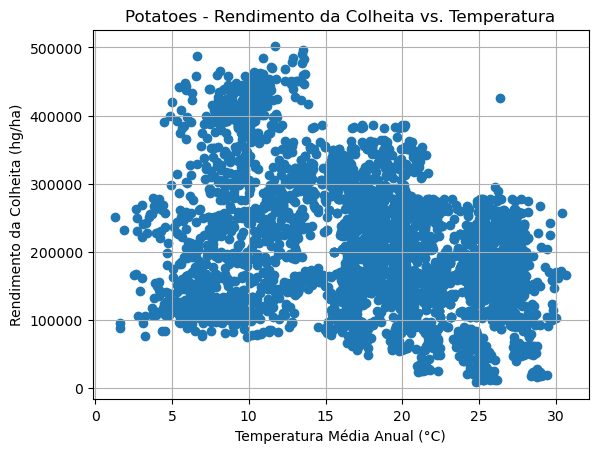

In [4]:
    plt.scatter(product_crop['avg_temp'], product_crop['hg/ha_yield'])
    plt.title(f'{item} - Rendimento da Colheita vs. Temperatura')
    plt.xlabel('Temperatura Média Anual (°C)')
    plt.ylabel('Rendimento da Colheita (hg/ha)')
    plt.grid(True)
    plt.show()

**O que Não Fazer (Armadilhas Comuns):**

*   **Não modelar às cegas:** O gráfico acima sugere uma relação negativa fraca para as batatas. Construir um modelo assumindo uma relação positiva seria contraprodutivo.
*   **Não ignorar a escala:** O rendimento está na casa das centenas de milhares (100.000 a 450.000). Saber isso é fundamental para definir priors razoáveis no nosso primeiro modelo.

## Parte 2: Construindo o Primeiro Modelo de Regressão Bayesiana

Vamos traduzir a equação de regressão linear, $y(t) = a + bt + \epsilon$, para um modelo PyMC.

*   $y(t)$: Nossa variável alvo (Rendimento da Colheita).
*   $t$: Nossa variável preditora (Temperatura).
*   $a$: O intercepto (valor de $y$ quando $t=0$).
*   $b$: O coeficiente angular (o impacto de uma unidade de $t$ em $y$).
*   $\epsilon$: O erro do modelo, que assumimos seguir uma distribuição de probabilidade.

### 2.1. Definindo os Priors (O Coração da Modelagem Bayesiana)

No paradigma Bayesiano, expressamos nossa crença inicial sobre os parâmetros ($a$, $b$, $\epsilon$) através de distribuições de probabilidade chamadas **priors**.

**Como Pensar sobre os Priors (Modelo Não Normalizado):**

*   **Parâmetro `a` (Intercepto):** Olhando o gráfico, o rendimento parece estar na faixa de 100.000 a 400.000. Um prior `Normal(100000, 20000)` expressa uma crença inicial de que o intercepto está por volta de 100.000, mas com uma incerteza considerável.
*   **Parâmetro `b` (Inclinação):** Vemos uma tendência negativa. Um prior `Normal(-2000, 10000)` reflete nossa crença em uma inclinação negativa, mas o desvio padrão muito grande permite que os dados corrijam essa crença se ela estiver errada.
*   **Parâmetro `eps` (Erro):** Este é o desvio padrão dos dados em torno da linha de regressão. Ele não pode ser negativo. Portanto, uma distribuição `HalfNormal` (uma Normal truncada em zero) é a escolha correta.

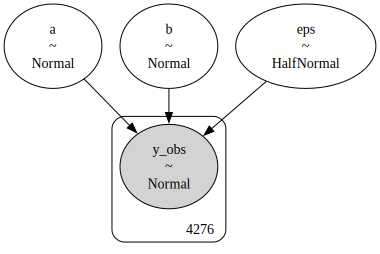

In [5]:
t = product["avg_temp"].values
obs = product["hg/ha_yield"].values

with pm.Model() as crop_model:
  # Priors baseados na escala original dos dados
  a = pm.Normal("a", 100000, 20000)
  b = pm.Normal("b", -2000, 10000)
  
  # Prior para o desvio-padrão do erro (HalfNormal é a melhor prática)
  eps = pm.HalfNormal("eps", 50000) 

  # A equação determinística do modelo
  mu = a + b * t
  
  # Likelihood: Conecta o modelo aos dados observados
  likelihood = pm.Normal("y_obs", mu, eps, observed=obs)

pm.model_to_graphviz(crop_model)

### 2.2. Amostragem e Análise da Posterior

O PyMC usa algoritmos MCMC (como o NUTS) para amostrar da **distribuição posterior** — a distribuição de probabilidade atualizada dos nossos parâmetros *após* eles terem sido confrontados com os dados. 

In [6]:
with crop_model:
  trace = pm.sample(2000, tune=1000, cores=1)

 Progress                    Draws   Divergences   Step size   Grad evals   Sampling Speed   Elapsed   Remaining  
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  ━━━━━━━━━━━━━━━━━━━━━━━━━   3000    0             0.33        15           396.65 draws/s   0:00:07   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━   3000    0             0.59        7            208.26 draws/s   0:00:14   0:00:00

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 14 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


**Interpretando os Resultados:**

*   `pm.summary(trace)`: Fornece um resumo estatístico da posterior. `mean` é a nossa melhor estimativa pontual, `sd` quantifica a incerteza, e `hdi` (Highest Density Interval) nos dá um intervalo de credibilidade de 94%.
*   `az.plot_posterior(trace)`: Visualiza as distribuições. Se a distribuição de `b` estiver majoritariamente abaixo de zero, temos forte evidência de uma relação negativa.

           mean        sd      hdi_3%     hdi_97%  mcse_mean  mcse_sd  \
a    286841.431  3727.830  279913.311  293847.607    105.371   72.046   
b     -4623.253   184.627   -4978.347   -4288.311      5.143    3.705   
eps   86664.698   930.987   84905.538   88343.190     19.108   16.356   

     ess_bulk  ess_tail  r_hat  
a      1244.0    1417.0    1.0  
b      1283.0    1383.0    1.0  
eps    2372.0    2114.0    1.0  


array([<Axes: title={'center': 'a'}>, <Axes: title={'center': 'b'}>,
       <Axes: title={'center': 'eps'}>], dtype=object)

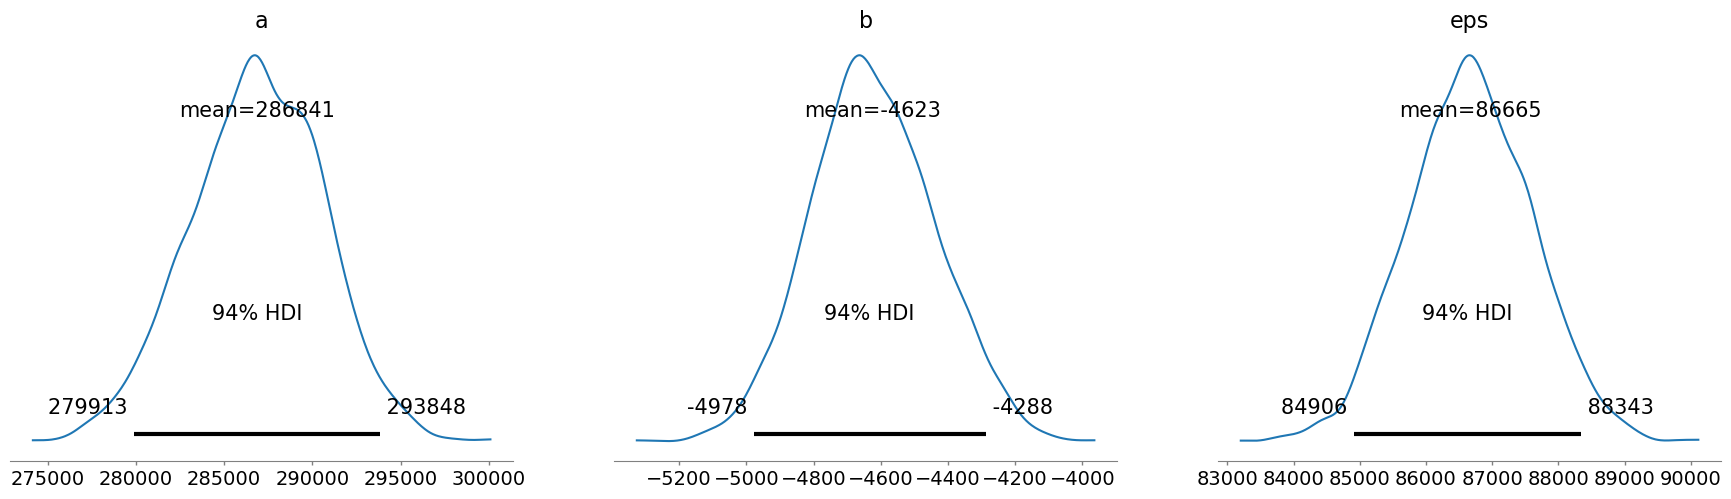

In [7]:
print(pm.summary(trace))
az.plot_posterior(trace)

### 2.3. Visualizando a Incerteza do Modelo

A beleza da abordagem Bayesiana é que não obtemos uma única linha, mas sim uma distribuição de linhas plausíveis que são consistentes com os dados.


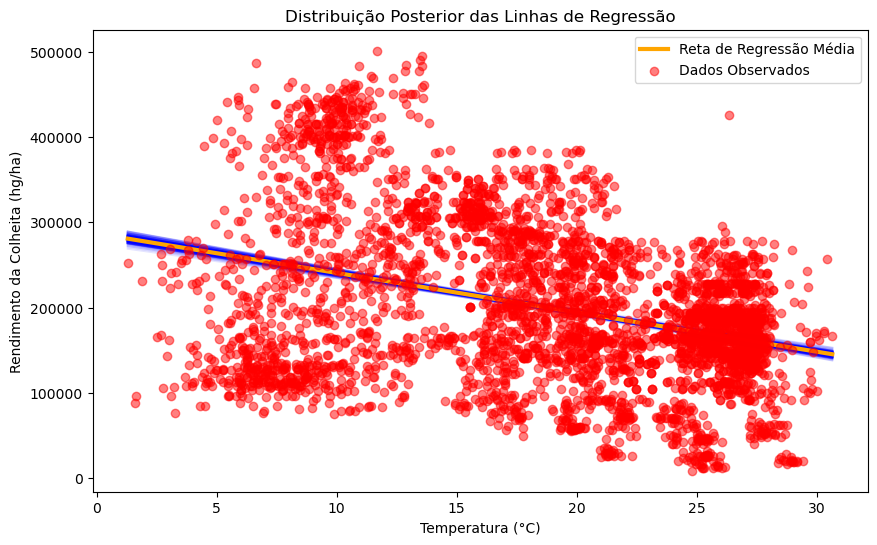

In [8]:
a_samples = trace.posterior["a"].values.flatten()
b_samples = trace.posterior["b"].values.flatten()
t_values = np.linspace(t.min(), t.max(), 100)

plt.figure(figsize=(10, 6))

# Plotar um subconjunto de linhas da posterior para mostrar a incerteza
for i in range(0, len(a_samples), 20): # Plota 1 a cada 20 amostras
    plt.plot(t_values, a_samples[i] + b_samples[i] * t_values, color="blue", alpha=0.1)

# Plotar a média da posterior como nossa "melhor estimativa"
mean_a = a_samples.mean()
mean_b = b_samples.mean()
plt.plot(t_values, mean_a + mean_b * t_values, color="orange", lw=3, label="Reta de Regressão Média")
plt.scatter(t, obs, color="red", label="Dados Observados", alpha=0.5, zorder=5)

plt.xlabel("Temperatura (°C)")
plt.ylabel("Rendimento da Colheita (hg/ha)")
plt.title("Distribuição Posterior das Linhas de Regressão")
plt.legend()
plt.show()

## Parte 3: A Vantagem da Normalização

Trabalhar com dados na escala original torna a escolha de priors difícil e não reutilizável. A **normalização** (ou padronização) transforma os dados para terem média 0 e desvio padrão 1, o que nos permite usar priors padrão e melhora a eficiência da amostragem.

In [9]:
# Normalizando a variável de saída
obs_mean = obs.mean()
obs_std = obs.std()
obs_norm = (obs - obs_mean) / obs_std

with pm.Model() as crop_model_norm:
  # Priors padrão para dados normalizados
  a = pm.Normal("a", 0, 1)
  b = pm.Normal("b", 0, 1)
  eps = pm.HalfNormal("eps", 1)

  mu = a + b * t
  likelihood = pm.Normal("y_obs", mu, eps, observed=obs_norm)

with crop_model_norm:
  trace_norm = pm.sample(2000, tune=1000, cores=1)

print(pm.summary(trace_norm))

 Progress                    Draws   Divergences   Step size   Grad evals   Sampling Speed   Elapsed   Remaining  
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  ━━━━━━━━━━━━━━━━━━━━━━━━━   3000    0             0.41        15           596.39 draws/s   0:00:05   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━   3000    0             0.23        3            300.61 draws/s   0:00:09   0:00:00

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 10 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


      mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
a    1.003  0.042   0.925    1.079      0.001    0.001    1869.0    1929.0   
b   -0.053  0.002  -0.057   -0.049      0.000    0.000    1885.0    2012.0   
eps  0.928  0.010   0.909    0.948      0.000    0.000    2165.0    1855.0   

     r_hat  
a      1.0  
b      1.0  
eps    1.0  


**Atenção:** Os coeficientes `a` e `b` agora são interpretados na escala normalizada. Um `b` de -0.05 significa que para cada aumento de 1°C, o rendimento diminui em 0.05 desvios-padrão.


## Parte 4: Regularização Através de Priors (Ridge e Lasso)

Regularização previne o overfitting. Na modelagem Bayesiana, ela é uma consequência natural da escolha dos priors.

### 4.1. Regressão Ridge (Prior Normal)

O modelo `crop_model_norm` que acabamos de criar já é uma **Regressão Ridge Bayesiana**. Usar um prior **Normal** nos coeficientes é matematicamente análogo a adicionar uma penalidade L2 (soma dos quadrados dos coeficientes), que "encolhe" os coeficientes em direção a zero, resultando em modelos mais estáveis.

### 4.2. Regressão Lasso (Prior Laplace)

A Regressão Lasso (penalidade L1) é famosa por sua capacidade de fazer seleção de variáveis, forçando alguns coeficientes a serem exatamente zero. O equivalente Bayesiano é usar um prior **Laplace**. A distribuição de Laplace tem um pico agudo em zero, tornando este valor muito mais provável para os coeficientes.

In [10]:
with pm.Model() as crop_lasso:
  # Trocamos os priors de Normal para Laplace
  a = pm.Laplace("a", 0, 1)
  b = pm.Laplace("b", 0, 1)
  eps = pm.HalfNormal("eps", 1)

  mu = a + b * t
  likelihood = pm.Normal("y_obs", mu, eps, observed=obs_norm)

with crop_lasso:
  trace_lasso = pm.sample(2000, tune=1000, cores=1)

 Progress                    Draws   Divergences   Step size   Grad evals   Sampling Speed   Elapsed   Remaining  
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  ━━━━━━━━━━━━━━━━━━━━━━━━━   3000    0             0.46        1            648.52 draws/s   0:00:04   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━   3000    0             0.42        7            285.47 draws/s   0:00:10   0:00:00

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 11 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


## Parte 5: Criando um Modelo Robusto a Outliers

A regressão linear padrão é muito sensível a outliers, pois a distribuição Normal penaliza fortemente os pontos distantes da média. A **distribuição t de Student**, com suas "caudas pesadas", é mais tolerante a esses pontos, tornando o modelo mais robusto.

A distribuição t tem um parâmetro extra, `nu` (graus de liberdade), que controla a "grossura" das caudas. Em vez de fixar `nu`, podemos deixar o modelo aprender seu valor a partir dos dados.

In [11]:
with pm.Model() as crop_robust:
  a = pm.Normal("a", 0, 1)
  b = pm.Normal("b", 0, 1)
  eps = pm.HalfNormal("eps", 1)
  
  # Prior para os graus de liberdade. Exponencial é uma escolha comum.
  # Um nu pequeno indica caudas pesadas (outliers presentes)
  df = pm.Exponential("df", 1)

  # Trocamos o Likelihood de Normal para StudentT
  likelihood = pm.StudentT("y_obs", nu=df, mu=a+b*t, sigma=eps, observed=obs_norm)

with crop_robust:
  trace_robust = pm.sample(2000, tune=1000, cores=1)

 Progress                    Draws   Divergences   Step size   Grad evals   Sampling Speed   Elapsed   Remaining  
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  ━━━━━━━━━━━━━━━━━━━━━━━━━   3000    0             0.41        7            268.81 draws/s   0:00:11   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━   3000    0             0.45        7            144.63 draws/s   0:00:20   0:00:00

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 21 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


## Parte 6: Comparando Modelos de Forma Criteriosa

Qual modelo é o melhor? A métrica padrão para isso é a **ELPD LOO**, que estima o poder de previsão do modelo em dados não vistos.

**O Fluxo de Trabalho Correto e a Correção Crucial:**

A função `az.compare` precisa do **log-likelihood** de cada ponto de dado para calcular a ELPD LOO. Por padrão, `pm.sample()` não armazena essa informação para economizar memória. Se tentarmos comparar os `traces` diretamente, encontraremos um erro.

A solução é usar `pm.compute_log_likelihood()` após a amostragem, dentro do contexto de cada modelo, para calcular e anexar essa informação vital ao objeto `trace`.


Computing ... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00

Executando a comparação de modelos...

--- Tabela de Comparação de Modelos ---
        rank     elpd_loo     p_loo  elpd_diff        weight         se  \
Lasso      0 -5750.356346  3.133574   0.000000  1.000000e+00  42.592575   
Ridge      1 -5750.505368  3.277019   0.149022  3.885781e-15  42.544398   
Robust     2 -5768.712160  3.398615  18.355814  0.000000e+00  43.632262   

             dse  warning scale  
Lasso   0.000000    False   log  
Ridge   0.048291    False   log  
Robust  2.360166    False   log  


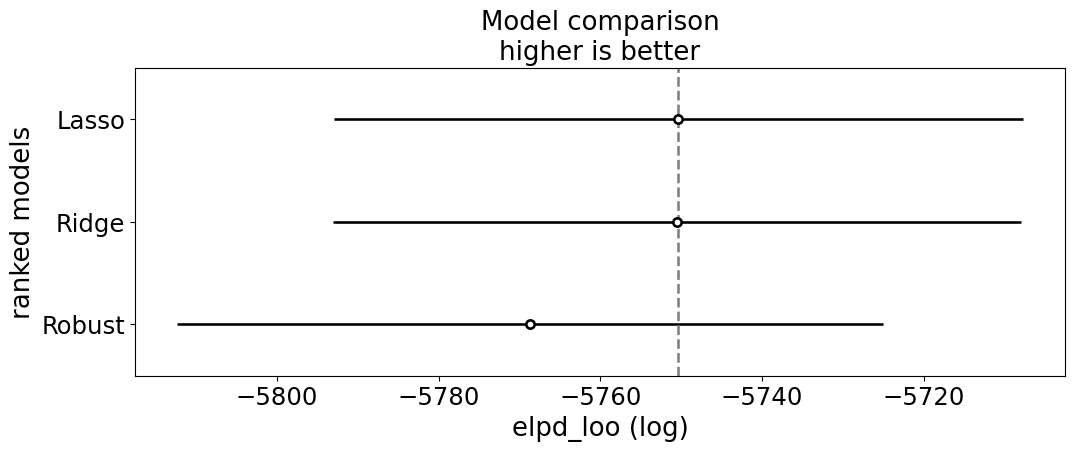

In [12]:
# Passo 1: Calcular o log-likelihood para cada modelo
print("Calculando log-likelihood para o modelo Ridge...")
with crop_model_norm:
    pm.compute_log_likelihood(trace_norm)

print("Calculando log-likelihood para o modelo Lasso...")
with crop_lasso:
    pm.compute_log_likelihood(trace_lasso)

print("Calculando log-likelihood para o modelo Robusto...")
with crop_robust:
    pm.compute_log_likelihood(trace_robust)

# Passo 2: Criar o dicionário com os traces enriquecidos
model_dict = {
    "Ridge": trace_norm,
    "Lasso": trace_lasso,
    "Robust": trace_robust
}

# Passo 3: Realizar a comparação
print("Executando a comparação de modelos...")
model_compare = az.compare(model_dict)

print("\n--- Tabela de Comparação de Modelos ---")
print(model_compare)
az.plot_compare(model_compare, figsize=(12, 4));

**Interpretando a Tabela de Comparação:**

*   **rank:** O melhor modelo (maior ELPD LOO) tem rank 0.
*   **elpd_loo:** A pontuação principal. Valores mais altos são melhores.
*   **weight:** A probabilidade de cada modelo ser o melhor. Pesos próximos a 1 indicam alta confiança no modelo de topo.
*   **dse:** O erro padrão da diferença entre a ELPD de um modelo e a do melhor. Se `elpd_diff` for menor que `2 * dse`, a diferença entre os modelos não é considerada significativa.

## Parte 7: Solução dos Exercícios

### Exercício 1: Modelo com Prior "Flat" (Sem Regularização)

Um prior "flat" (ou não informativo) tenta não influenciar o resultado. Isso aproxima a regressão Bayesiana da regressão de mínimos quadrados ordinários.

Computing ... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00


--- Comparação Incluindo Modelo Flat ---
        rank     elpd_loo     p_loo  elpd_diff        weight         se  \
Lasso      0 -5750.356346  3.133574   0.000000  1.000000e+00  42.592575   
Flat       1 -5750.373878  3.144260   0.017532  4.926615e-14  42.533452   
Ridge      2 -5750.505368  3.277019   0.149022  2.383589e-14  42.544398   
Robust     3 -5768.712160  3.398615  18.355814  1.809664e-14  43.632262   

             dse  warning scale  
Lasso   0.000000    False   log  
Flat    0.085211    False   log  
Ridge   0.048291    False   log  
Robust  2.360166    False   log  


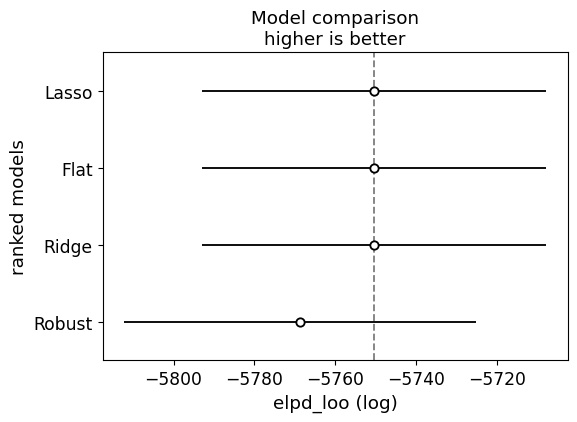

In [13]:
# Modelo com Prior Flat
with pm.Model() as crop_flat:
  a = pm.Flat("a")
  b = pm.Flat("b")
  eps = pm.HalfNormal("eps", 1)
  mu = a + b * t
  likelihood = pm.Normal("y_obs", mu, eps, observed=obs_norm)

with crop_flat:
  trace_flat = pm.sample(2000, tune=1000, cores=1)
  pm.compute_log_likelihood(trace_flat)

# Adicionando à comparação
model_dict_ex1 = {
    "Ridge": trace_norm,
    "Lasso": trace_lasso,
    "Robust": trace_robust,
    "Flat": trace_flat
}
compare_ex1 = az.compare(model_dict_ex1)
print("\n--- Comparação Incluindo Modelo Flat ---")
print(compare_ex1)
az.plot_compare(compare_ex1);

# Análise: Frequentemente, os modelos regularizados (Ridge, Lasso) superam o Flat em poder preditivo,
# pois a regularização ajuda a evitar o ajuste ao ruído da amostra, melhorando a generalização.

### Exercício 2, 3 e 4: Análise para Soja (Soybeans)

Repetimos o processo para uma nova cultura, aplicando todas as boas práticas.

## Dicas Finais, Alternativas e Próximos Passos

*   **Priors Fracamente Informativos:** Em vez de priors `Flat`, que podem ser problemáticos, priors fracamente informativos como `Normal(0, 1)` (para dados normalizados) são quase sempre a melhor escolha. Eles fornecem regularização suave sem enviesar fortemente os resultados.
*   **Verificação Preditiva Posterior (PPC):** Após escolher seu melhor modelo, valide-o! Gere dados simulados a partir do seu modelo e veja se eles se parecem com os dados reais. Use `az.plot_ppc()` para fazer isso. É um teste de sanidade essencial.
*   **Cuidado com a Causalidade:** Lembre-se, regressão identifica **correlação**, não **causação**. Uma correlação positiva entre pesticidas e rendimento ao longo do tempo pode ser causada por um terceiro fator, como a melhoria geral da tecnologia agrícola.
*   **Próximos Passos:**
    *   **Regressão Polinomial:** Se a relação não for linear, adicione termos como $b_2t^2$.
    *   **Modelos Hierárquicos:** Em vez de agregar os dados por ano, um modelo hierárquico poderia estimar uma relação global e, ao mesmo tempo, desvios específicos para cada país. Esta é uma abordagem muito mais poderosa e um passo natural na modelagem Bayesiana.